In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [2]:
SEED = 42
FOLDS = 5

In [3]:
df = pd.read_csv("historical_data.csv", parse_dates=["created_at", "actual_delivery_time"])
df

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,251,331.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,251,915.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,251,795.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0


In [4]:
df.drop(["estimated_order_place_duration", "estimated_store_to_consumer_driving_duration"], axis=1, inplace=True)
df.dtypes

market_id                          float64
created_at                  datetime64[ns]
actual_delivery_time        datetime64[ns]
store_id                             int64
store_primary_category              object
order_protocol                     float64
total_items                          int64
subtotal                             int64
num_distinct_items                   int64
min_item_price                       int64
max_item_price                       int64
total_onshift_dashers              float64
total_busy_dashers                 float64
total_outstanding_orders           float64
dtype: object

## Cleaning Data & EDA

In [5]:
df.isnull().sum()

market_id                     987
created_at                      0
actual_delivery_time            7
store_id                        0
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_dashers       16262
total_busy_dashers          16262
total_outstanding_orders    16262
dtype: int64

In [6]:
df = df.dropna(axis=0).reset_index(drop=True)
target = "order_fulfillment_time"
df[target] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
df = df.loc[(df[target] <= 120) & (df[target] >= 10) , :].reset_index(drop=True)
y = df[target].copy()
X = df.drop([target, "created_at", "actual_delivery_time"], axis=1)
X[["total_onshift_dashers", "total_busy_dashers", "total_outstanding_orders"]] = np.round(X[["total_onshift_dashers", "total_busy_dashers", "total_outstanding_orders"]])
X[["total_onshift_dashers", "total_busy_dashers", "total_outstanding_orders"]] = X[["total_onshift_dashers", "total_busy_dashers", "total_outstanding_orders"]].astype(int)

category = ["market_id", "store_id", "store_primary_category", "order_protocol"]
numeric = [col for col in X.columns if col not in category]
        
print("Numerical features: ", numeric)
print("Categorical features: ", category)

Numerical features:  ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
Categorical features:  ['market_id', 'store_id', 'store_primary_category', 'order_protocol']


In [7]:
y.describe()

count    175249.000000
mean         47.105860
std          16.896579
min          10.116667
25%          35.033333
50%          44.250000
75%          56.116667
max         119.933333
Name: order_fulfillment_time, dtype: float64

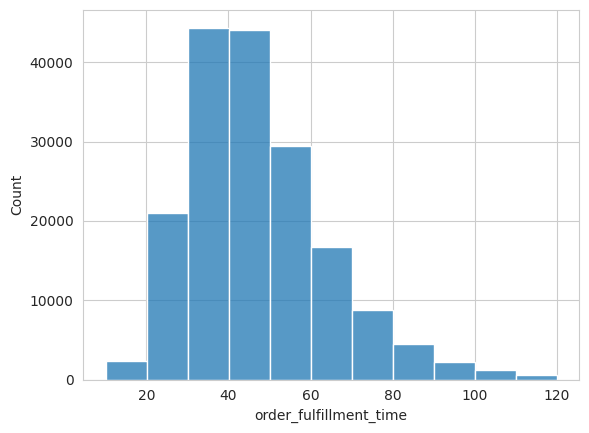

In [8]:
sns.histplot(data=df, x=target, bins=11)
plt.show()

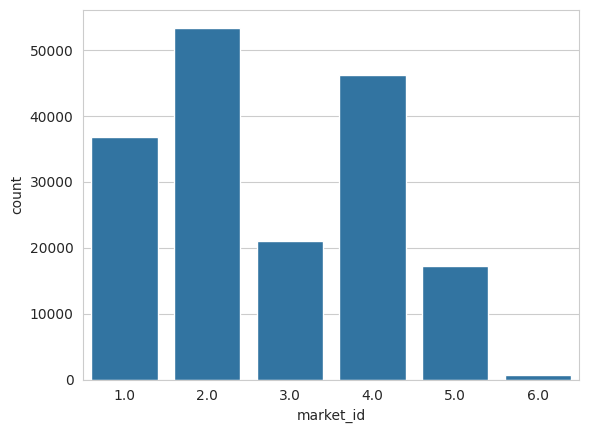

In [9]:
sns.countplot(data=df, x="market_id")
plt.show()

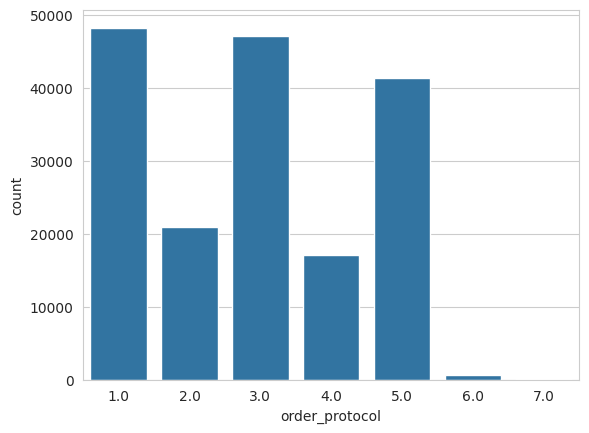

In [10]:
sns.countplot(data=df, x="order_protocol")
plt.show()

In [11]:
df["store_primary_category"].nunique()

73

In [12]:
df["store_id"].nunique()

5636

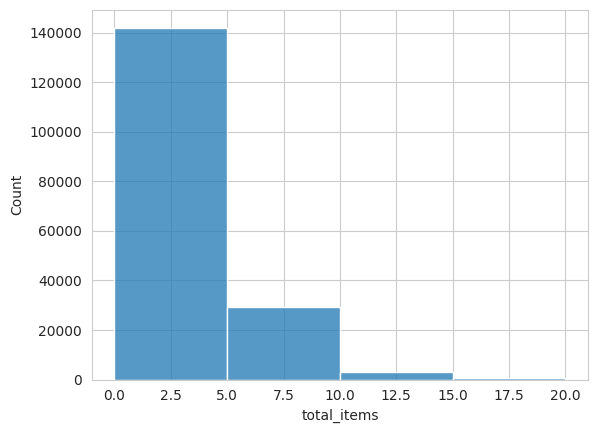

In [13]:
sns.histplot(data=df, x="total_items", binrange=(0, 20), bins=4)
plt.show()

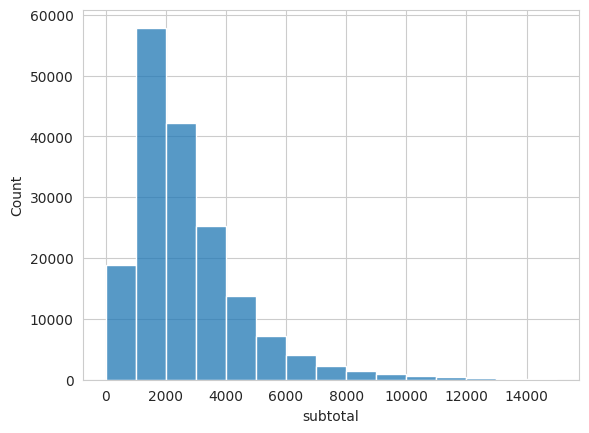

In [14]:
sns.histplot(data=df, x="subtotal", binrange=(0, 15000), bins=15)
plt.show()

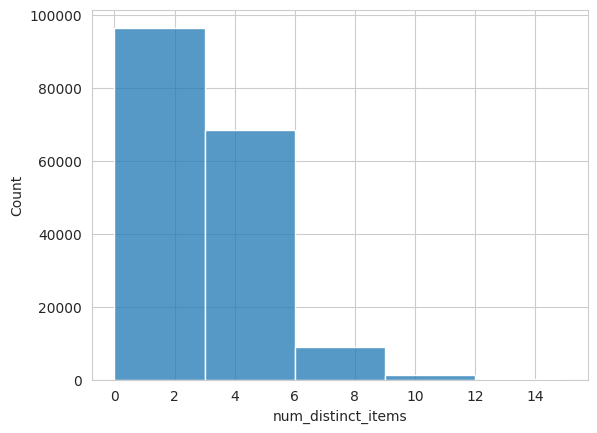

In [15]:
sns.histplot(data=df, x="num_distinct_items", binrange=(0, 15), bins=5)
plt.show()

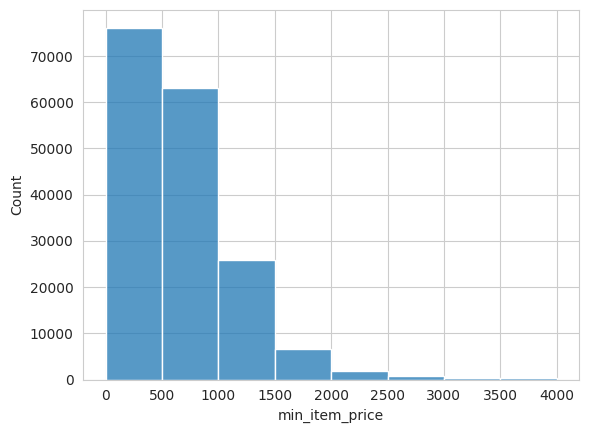

In [16]:
sns.histplot(data=df, x="min_item_price", binrange=(0, 4000), bins=8)
plt.show()

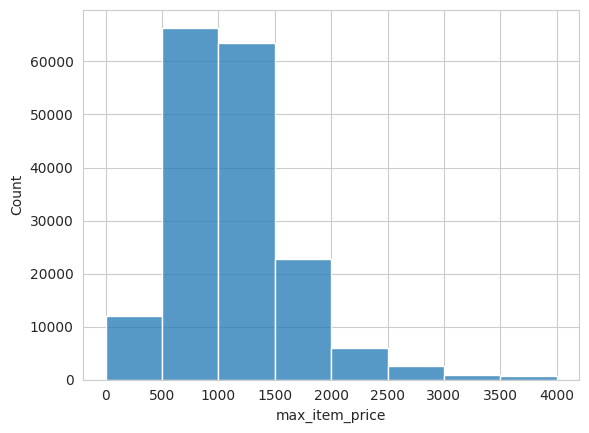

In [17]:
sns.histplot(data=df, x="max_item_price", binrange=(0, 4000), bins=8)
plt.show()

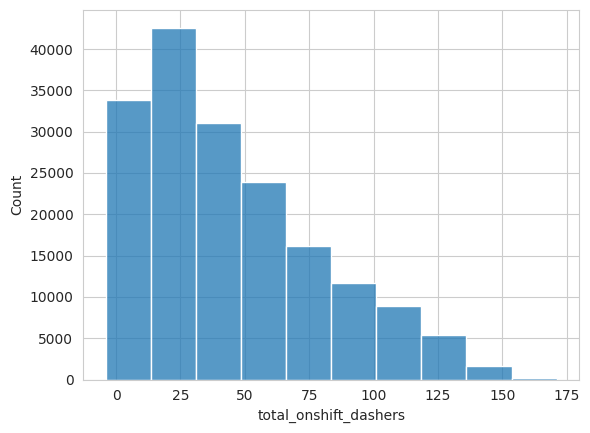

In [18]:
sns.histplot(data=df, x="total_onshift_dashers", bins=10)
plt.show()

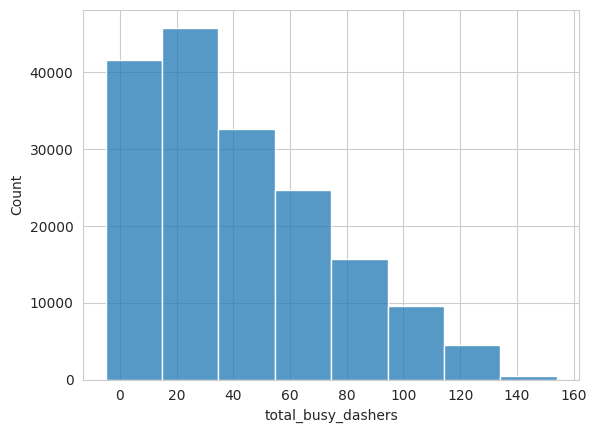

In [19]:
sns.histplot(data=df, x="total_busy_dashers", bins=8)
plt.show()

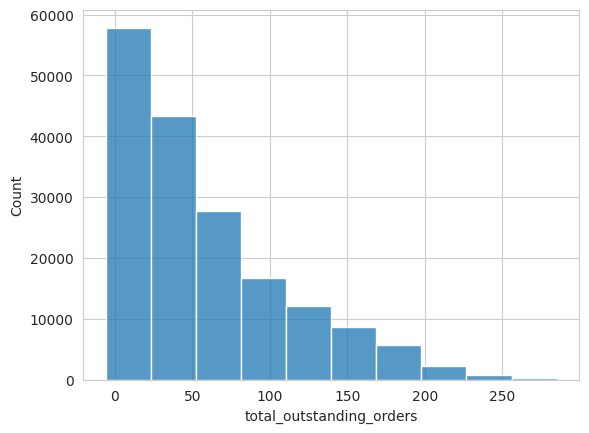

In [20]:
sns.histplot(data=df, x="total_outstanding_orders", bins=10)
plt.show()

In [21]:
df[numeric + [target]].corr()[target].drop(index=target)

total_items                 0.123313
subtotal                    0.228892
num_distinct_items          0.167929
min_item_price              0.014965
max_item_price              0.142761
total_onshift_dashers       0.087182
total_busy_dashers          0.108403
total_outstanding_orders    0.201594
Name: order_fulfillment_time, dtype: float64

## Feature Engineering + Model Training & Hyperparameter Tuning

### Random Forest

In [22]:
rf_pipeline = Pipeline(
    [("encoder", ce.TargetEncoder(cols=category)),
     ("regressor", RandomForestRegressor(random_state=SEED, n_jobs=-1))]
)

rf_param_grid = {
    "regressor__n_estimators": [20, 50, 100],
    "regressor__max_depth": [10, 15, 20],
    "regressor__min_samples_leaf": [0.01, 0.02, 0.05],
    "regressor__min_samples_split": [0.05, 0.1],
}

In [23]:
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, scoring="neg_mean_absolute_error", cv=FOLDS)
rf_grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoder',
                                        TargetEncoder(cols=['market_id',
                                                            'store_id',
                                                            'store_primary_category',
                                                            'order_protocol'])),
                                       ('regressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             param_grid={'regressor__max_depth': [10, 15, 20],
                         'regressor__min_samples_leaf': [0.01, 0.02, 0.05],
                         'regressor__min_samples_split': [0.05, 0.1],
                         'regressor__n_estimators': [20, 50, 100]},
             scoring='neg_mean_absolute_error')

In [24]:
print("Best hyperparameters: ", rf_grid_search.best_params_)
print("Best mean absolute error: ", -1 * rf_grid_search.best_score_)

Best hyperparameters:  {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 0.01, 'regressor__min_samples_split': 0.05, 'regressor__n_estimators': 20}
Best mean absolute error:  12.385300277860923


### XGBoost

In [25]:
xgb_pipeline = Pipeline(
    [("encoder", ce.TargetEncoder(cols=category)),
     ("regressor", XGBRegressor(objective="reg:squarederror", random_state=SEED, n_jobs=-1, device="cuda"))]
)

xgb_param_grid = {
    "regressor__learning_rate": [0.1, 0.01],
    "regressor__n_estimators": [20, 50, 100, 200],
    "regressor__max_depth": [4, 6],
    "regressor__subsample": [1, 0.9],
    "regressor__min_child_weight": [1, 2],
}

In [26]:
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, scoring="neg_mean_absolute_error", cv=FOLDS)
xgb_grid_search.fit(X, y)

/home/hwting/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoder',
                                        TargetEncoder(cols=['market_id',
                                                            'store_id',
                                                            'store_primary_category',
                                                            'order_protocol'])),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device='cuda',
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'regressor__learning_rate': [0.1, 0.01],
                         'regressor__max_depth': [4, 6],
                         'regressor__min_child_weight': [1, 2],
                         'regressor__n_estimators': [20, 50, 100, 200],
                         'regressor__subsample': [1, 0.9]},
             scoring='neg_mean_absolute_error')

In [27]:
print("Best hyperparameters: ", xgb_grid_search.best_params_)
print("Best mean absolute error: ", -1 * xgb_grid_search.best_score_)

Best hyperparameters:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 200, 'regressor__subsample': 1}
Best mean absolute error:  11.270279837904505


## Save Column Attributes

In [28]:
col_attr = {}
for col in X.columns:
    if col in category:
        if X.dtypes[col] == "object":
            col_attr[col] = ("category", list(X[col].unique()))
        else:
            col_attr[col] = ("category", list(map(int, X[col].unique())))
    else:
        col_attr[col] = ("numeric", str(X.dtypes[col]))
        
with open("columns_attribute.json", "w") as f_out:
    json.dump(col_attr, f_out, indent=4)